# Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# PreProcessing and Visualising Tweets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data from CSV file
df = pd.read_csv('/content/covid19_tweets_with_severity.csv')


# Filter out rows where user_verified is True
df_verified = df[df['user_verified'] == True].copy()

# Select relevant columns
df_processed = df_verified[['user_location', 'user_followers', 'date', 'text','severity']].copy()
df_processed.dropna(subset=['date'], inplace=True)
df_processed['date'] = pd.to_datetime(df_processed['date'], errors='coerce')

# Extract date and hour from the 'date' column
df_processed['date_hour'] = df_processed['date'].dt.strftime('%Y-%m-%d %H')
tweet_counts_hourly = df_processed.groupby('date_hour').size()

# Display the first few rows of the preprocessed dataset
print("Preprocessed dataset:")
print(df_processed.head())



<ipython-input-1-e63024afc561>:5: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/covid19_tweets_with_severity.csv')


Preprocessed dataset:
         user_location  user_followers                date  \
1         New York, NY          2253.0 2020-07-25 12:27:17   
21       #AFRICA #MENA         10661.0 2020-07-25 12:26:31   
25       Mumbai, India       1215920.0 2020-07-25 12:26:26   
39  Bethesda, Maryland         32008.0 2020-07-25 12:26:00   
43    New Delhi, India         52186.0 2020-07-25 12:25:49   

                                                 text  severity      date_hour  
1   Hey @Yankees @YankeesPR and @MLB - wouldn't it...       3.0  2020-07-25 12  
21  Coronavirus - South Africa: COVID-19 update fo...       3.0  2020-07-25 12  
25  #Kolar\nNeed #Blood Type :  B-positive\nAt : J...       4.0  2020-07-25 12  
39  We released two new #COVID19 podcast episodes ...       1.0  2020-07-25 12  
43  #Delhi reports 1,142 #COVID19 positive cases a...       1.0  2020-07-25 12  


In [ ]:
print("Maximum Date:", df_processed['date'].max())
print("Minimum Date:", df_processed['date'].min())


Maximum Date: 2020-08-30 09:06:53
Minimum Date: 2020-07-24 23:47:12


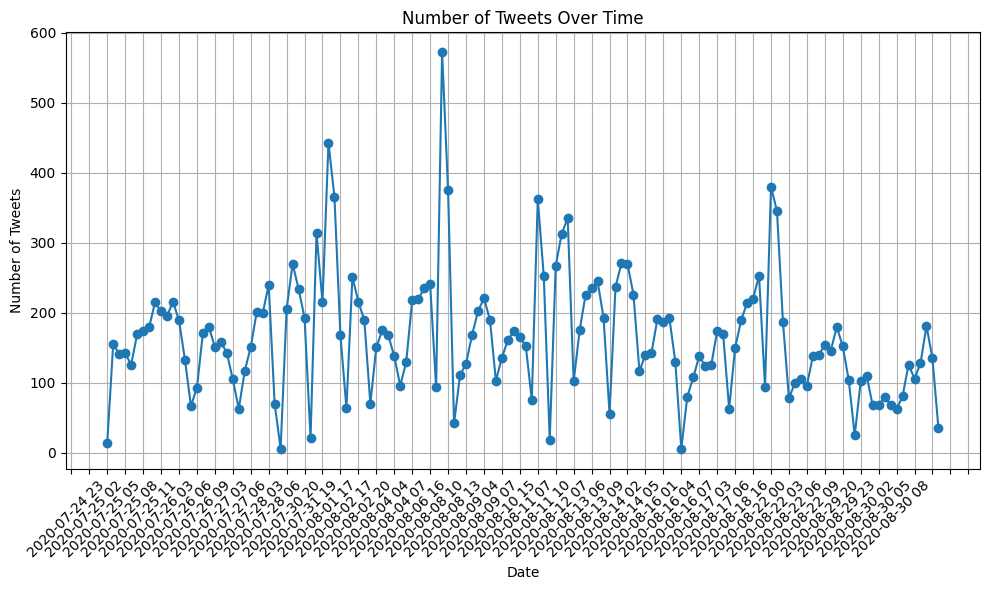

In [ ]:
# Group by date and hour, then calculate the tweet counts
tweet_counts= df_processed.groupby('date_hour').size()

# Plot the number of tweets over time
plt.figure(figsize=(10, 6))
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)

# Set x-axis tick locator to show labels at specific intervals (e.g., every 3 days)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels for better readability
plt.tight_layout()
plt.show()


# Training and Testing the LSTM model with respect to tweet count over time

In [ ]:

# Normalize input data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(tweet_counts.values.reshape(-1, 1))
tweet_counts_tensor = torch.tensor(normalized_data, dtype=torch.float32)

# Define training and testing data sizes
train_size = int(0.8 * len(tweet_counts_tensor))
test_size = len(tweet_counts_tensor) - train_size

# Split data into training and testing sets
train_data = tweet_counts_tensor[:train_size]
test_data = tweet_counts_tensor[train_size:]

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
input_size = 1  # Number of features (tweet counts)
hidden_size = 128  # Number of hidden units (increased for more complexity)
num_layers = 2  # Number of LSTM layers (increased for more complexity)
model = LSTMModel(input_size, hidden_size, num_layers)


# Define DataLoader for training and testing data
train_dataset = TensorDataset(train_data[:-1], train_data[1:])  # Input: previous tweet count, Target: current tweet count
test_dataset = TensorDataset(test_data[:-1], test_data[1:])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_epochs=500
best_loss = float('inf')  # Initialize best loss to positive infinity
best_optimizer = None
best_learning_rate = None

def train_model(optimizer, learning_rate):
    global best_loss, best_optimizer, best_learning_rate  # Access the global best_loss variable
    # Instantiate the model
    model = LSTMModel(input_size, hidden_size, num_layers)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    # Training the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-1))
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

        # Check if current loss is lower than the best loss
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_optimizer = optimizer.__class__.__name__
            best_learning_rate = learning_rate
            # Save the model state
            torch.save(model.state_dict(), 'best_model.pth')

# Hyperparameter tuning
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
learning_rates = [0.01, 0.001]

for optimizer_cls in optimizers:
    for lr in learning_rates:
        print(f"Optimizer: {optimizer_cls.__name__}, Learning Rate: {lr}")
        train_model(optimizer_cls, lr)
        print()

# Print the best hyperparameters
print(f"Best Hyperparameters:")
print(f"Optimizer: {best_optimizer}, Learning Rate: {best_learning_rate}")

# After the hyperparameter tuning loop, load the best model state
best_model = LSTMModel(input_size, hidden_size, num_layers)
best_model.load_state_dict(torch.load('best_model.pth'))



Optimizer: Adam, Learning Rate: 0.01
Epoch [100/500], Loss: 0.020282316952943802
Epoch [200/500], Loss: 0.017458388581871986
Epoch [300/500], Loss: 0.014751436188817024
Epoch [400/500], Loss: 0.011435074731707573
Epoch [500/500], Loss: 0.010886576026678085

Optimizer: Adam, Learning Rate: 0.001
Epoch [100/500], Loss: 0.018609669059515
Epoch [200/500], Loss: 0.019160890951752663
Epoch [300/500], Loss: 0.019487794488668442
Epoch [400/500], Loss: 0.019809896126389503
Epoch [500/500], Loss: 0.02010553702712059

Optimizer: SGD, Learning Rate: 0.01
Epoch [100/500], Loss: 0.01931626908481121
Epoch [200/500], Loss: 0.019315671175718307
Epoch [300/500], Loss: 0.019315071403980255
Epoch [400/500], Loss: 0.019314469769597054
Epoch [500/500], Loss: 0.019313869997859

Optimizer: SGD, Learning Rate: 0.001
Epoch [100/500], Loss: 0.02235788106918335
Epoch [200/500], Loss: 0.018800389021635056
Epoch [300/500], Loss: 0.019126972183585167
Epoch [400/500], Loss: 0.019250286743044853
Epoch [500/500], Loss:

<All keys matched successfully>

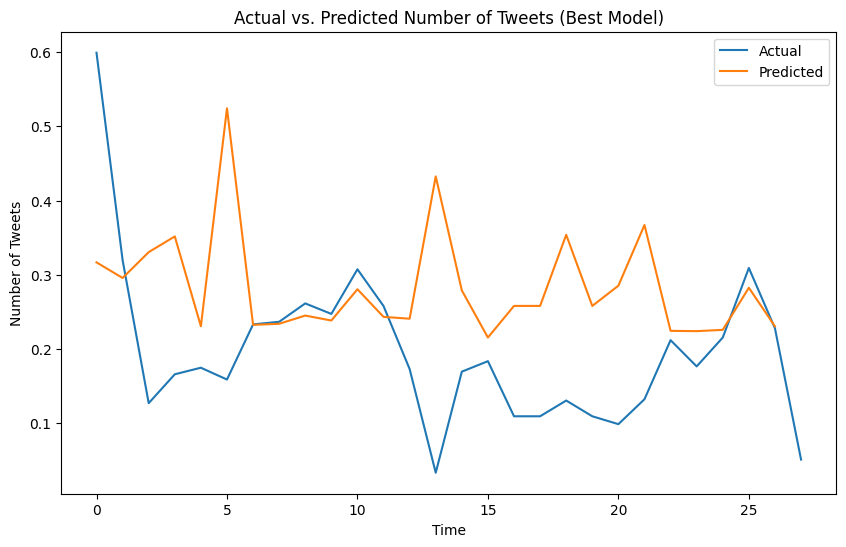

In [ ]:

# Evaluation using the best model
best_model.eval()
with torch.no_grad():
    predictions = []
    for inputs, targets in test_loader:
        outputs = best_model(inputs.unsqueeze(-1))
        predictions.append(outputs.numpy())

# Flatten the predictions
predictions = np.concatenate(predictions)

# Plot the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data.numpy(), label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Number of Tweets (Best Model)')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()



# Training and testing multi-layer perceptron neural network

In [ ]:
# Select relevant columns
df = df_verified[['user_location', 'text']]

# Count occurrences of each user location
location_counts = df['user_location'].value_counts()

# Find repetitions in the 'user_location' column
repetitions = location_counts[location_counts > 1]

# Filter the DataFrame to include only rows with repeated user locations
repeated_locations_df = df[df['user_location'].isin(repetitions.index)].copy()

# Add a new column to show the count of repetitions for each user location
repeated_locations_df.loc[:, 'count'] = repeated_locations_df.groupby('user_location')['user_location'].transform('size')

# Print the repetitions along with the corresponding text and count
if not repeated_locations_df.empty:
    print("Repetitions in user_location column along with corresponding text and count:")
    print(repeated_locations_df)
else:
    print("No repetitions found in user_location column.")



Repetitions in user_location column along with corresponding text and count:
              user_location  \
1              New York, NY   
21            #AFRICA #MENA   
25            Mumbai, India   
39       Bethesda, Maryland   
43         New Delhi, India   
...                     ...   
179071              Georgia   
179083        #AFRICA #MENA   
179087       Burlington, VT   
179091         New York, NY   
179092  Manila, Philippines   

                                                     text  count  
1       Hey @Yankees @YankeesPR and @MLB - wouldn't it...    250  
21      Coronavirus - South Africa: COVID-19 update fo...    180  
25      #Kolar\nNeed #Blood Type :  B-positive\nAt : J...    845  
39      We released two new #COVID19 podcast episodes ...      6  
43      #Delhi reports 1,142 #COVID19 positive cases a...    746  
...                                                   ...    ...  
179071  Standard &amp; Poor’s affirms Georgia at ‘BB’ ...      8  
179083  #Coron

In [ ]:
import pandas as pd
from textblob import TextBlob

# Assuming df_verified is your DataFrame with columns 'user_location' and 'text'

# Select relevant columns
df = df_verified[['user_location', 'text']].copy()

# Count occurrences of each user location
location_counts = df['user_location'].value_counts()

# Find repetitions in the 'user_location' column
repetitions_locations_df = location_counts[location_counts > 1].reset_index()
repetitions_locations_df.columns = ['user_location', 'count']

# Function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Calculate sentiment polarity for each text in the DataFrame
df.loc[:, 'sentiment'] = df['text'].apply(calculate_sentiment)

# Group by user_location and calculate the mean sentiment value for each location
mean_sentiment_per_location = df.groupby('user_location')['sentiment'].mean()

# Merge the mean sentiment value DataFrame with repetitions_locations_df
merged_df = pd.merge(repetitions_locations_df, mean_sentiment_per_location, left_on='user_location', right_index=True)

# Print the merged DataFrame with count and mean sentiment value
print("Mean sentiment value for each user location along with count of repetitions:")
print(merged_df)


Mean sentiment value for each user location along with count of repetitions:
                       user_location  count  sentiment
0                              India   1829   0.075903
1                      Mumbai, India    845   0.047791
2                   New Delhi, India    746   0.082796
3                          New Delhi    458   0.082894
4                     Washington, DC    436   0.113355
...                              ...    ...        ...
1318               Beverly Hills, CA      2   0.000000
1319             Rockdale County, GA      2   0.550000
1320     London and Middlesex County      2  -0.025000
1321                      Washington      2   0.325000
1322  Fun & Sun Capital of the World      2   0.000000

[1323 rows x 3 columns]


In [ ]:
# Select relevant columns
df = merged_df[['count', 'sentiment']]

# Normalize the 'count' column
scaler = MinMaxScaler()
df['count_scaled'] = scaler.fit_transform(df[['count']])

# Split the dataset into features and target
X = df['count_scaled'].values.reshape(-1, 1)  # Features
y = df['sentiment'].values.reshape(-1, 1)  # Target

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the neural network architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
def train_model(hidden_size, learning_rate):
    global best_loss, best_hidden_size, best_learning_rate  # Access the global best_loss variable
    # Instantiate the model
    model = MLP(input_size=1, hidden_size1=hidden_size, hidden_size2=hidden_size, output_size=1)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

        # Check if current loss is lower than the best loss
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_hidden_size = hidden_size
            best_learning_rate = learning_rate
            # Save the model state
            torch.save(model.state_dict(), 'best_model.pth')

# Hyperparameter tuning
hidden_sizes = [64, 128]
learning_rates = [0.01, 0.001]
best_loss = float('inf')  # Initialize best loss to positive infinity
best_hidden_size = None
best_learning_rate = None
num_epochs = 500
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}")
        train_model(hidden_size, lr)
        print()

# Print the best hyperparameters
print(f"Best Hyperparameters:")
print(f"Hidden Size: {best_hidden_size}, Learning Rate: {best_learning_rate}")

# After the hyperparameter tuning loop, load the best model state
best_model = MLP(input_size=1, hidden_size1=best_hidden_size, hidden_size2=best_hidden_size, output_size=1)
best_model.load_state_dict(torch.load('best_model.pth'))


Hidden Size: 64, Learning Rate: 0.01


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1058])) that is different to the input size (torch.Size([1058, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/500], Loss: 0.017908206209540367
Epoch [200/500], Loss: 0.017907263711094856
Epoch [300/500], Loss: 0.017907259985804558
Epoch [400/500], Loss: 0.01790725812315941
Epoch [500/500], Loss: 0.01790725812315941

Hidden Size: 64, Learning Rate: 0.001
Epoch [100/500], Loss: 0.0179111547768116
Epoch [200/500], Loss: 0.01790754683315754
Epoch [300/500], Loss: 0.01790732517838478
Epoch [400/500], Loss: 0.01790727861225605
Epoch [500/500], Loss: 0.017907273024320602

Hidden Size: 128, Learning Rate: 0.01
Epoch [100/500], Loss: 0.017907293513417244
Epoch [200/500], Loss: 0.01790725626051426
Epoch [300/500], Loss: 0.01790725439786911
Epoch [400/500], Loss: 0.01790725439786911
Epoch [500/500], Loss: 0.01790725439786911

Hidden Size: 128, Learning Rate: 0.001
Epoch [100/500], Loss: 0.01790732890367508
Epoch [200/500], Loss: 0.01790725812315941
Epoch [300/500], Loss: 0.01790725626051426
Epoch [400/500], Loss: 0.01790725626051426
Epoch [500/500], Loss: 0.01790725439786911

Best Hyperparamet

<All keys matched successfully>

# Implementing RNN with text and user_date

In [ ]:
# Load data from CSV file
df = pd.read_csv('/content/covid19_tweets_with_severity.csv')

# Filter out rows where user_verified is True
df_verified = df[df['user_verified'] == True].copy()

# Select relevant columns
df_processed = df_verified[['user_location', 'user_followers', 'date', 'text', 'severity']].copy()
df_processed.loc[:, 'user_location'] = df_processed['user_location'].fillna('')

# Convert 'date' column to datetime
df_processed['date'] = pd.to_datetime(df_processed['date'], errors='coerce')

# Find the minimum date in the dataset
min_date = df_processed['date'].min()

# Extract the time component in seconds since the minimum date
df_processed['time_seconds'] = (df_processed['date'] - min_date).dt.total_seconds()

# Convert the time component to seconds
df_processed['time_seconds'] = df_processed['time_seconds'].astype(int)

# Group by date and aggregate severity
df_grouped = df_processed.groupby(['date', 'time_seconds']).agg({'severity': 'mean'}).reset_index()

# Convert to numpy arrays
X = df_grouped[['date', 'time_seconds']].values
y = df_grouped['severity'].values


print("Data type of X:", X.dtype)
print("Shape of X:", X.shape)

print("Data type of y:", y.dtype)
print("Shape of y:", y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Convert elements in X_train and X_test to datetime objects
X_train_datetime = pd.to_datetime(X_train[:, 0]) + pd.to_timedelta(X_train[:, 1], unit='s')
X_test_datetime = pd.to_datetime(X_test[:, 0]) + pd.to_timedelta(X_test[:, 1], unit='s')

# Convert datetime objects to timestamps and create numpy arrays
X_train_numeric = np.array([[date.timestamp()] for date in X_train_datetime])
X_test_numeric = np.array([[date.timestamp()] for date in X_test_datetime])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_numeric, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_numeric, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



<ipython-input-25-98b72891dc0d>:2: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/covid19_tweets_with_severity.csv')


Data type of X: object
Shape of X: (20778, 2)
Data type of y: float64
Shape of y: (20778,)


In [ ]:
from sklearn.metrics import f1_score, precision_score
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Define model parameters
input_size = 1  # Assuming only time in seconds is the input
hidden_size = 128
output_size = 1

# Define the model
model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.unsqueeze(1))  # Unsqueeze to add batch dimension
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    mse = mean_squared_error(y_test_tensor, test_outputs)
    print(f'Mean Squared Error: {mse:.4f}')

    # Convert predictions to binary classes
    y_pred = np.round(test_outputs.numpy()).astype(int)
    y_true = y_test_tensor.numpy().astype(int)

    # Calculate F1 score and precision
    f1 = f1_score(y_true, y_pred, average='micro')
    precision = precision_score(y_true, y_pred, average='micro')

    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')



Epoch [1/50], Loss: 8.0824
Epoch [2/50], Loss: 3.3447
Epoch [3/50], Loss: 1.9254
Epoch [4/50], Loss: 2.7829
Epoch [5/50], Loss: 3.8932
Epoch [6/50], Loss: 4.0542
Epoch [7/50], Loss: 3.4263
Epoch [8/50], Loss: 2.5946
Epoch [9/50], Loss: 2.0348
Epoch [10/50], Loss: 1.9492
Epoch [11/50], Loss: 2.2414
Epoch [12/50], Loss: 2.6201
Epoch [13/50], Loss: 2.8116
Epoch [14/50], Loss: 2.7217
Epoch [15/50], Loss: 2.4373
Epoch [16/50], Loss: 2.1293
Epoch [17/50], Loss: 1.9469
Epoch [18/50], Loss: 1.9484
Epoch [19/50], Loss: 2.0850
Epoch [20/50], Loss: 2.2427
Epoch [21/50], Loss: 2.3164
Epoch [22/50], Loss: 2.2688
Epoch [23/50], Loss: 2.1382
Epoch [24/50], Loss: 2.0025
Epoch [25/50], Loss: 1.9300
Epoch [26/50], Loss: 1.9433
Epoch [27/50], Loss: 2.0133
Epoch [28/50], Loss: 2.0828
Epoch [29/50], Loss: 2.1049
Epoch [30/50], Loss: 2.0691
Epoch [31/50], Loss: 2.0018
Epoch [32/50], Loss: 1.9442
Epoch [33/50], Loss: 1.9255
Epoch [34/50], Loss: 1.9469
Epoch [35/50], Loss: 1.9849
Epoch [36/50], Loss: 2.0094
E

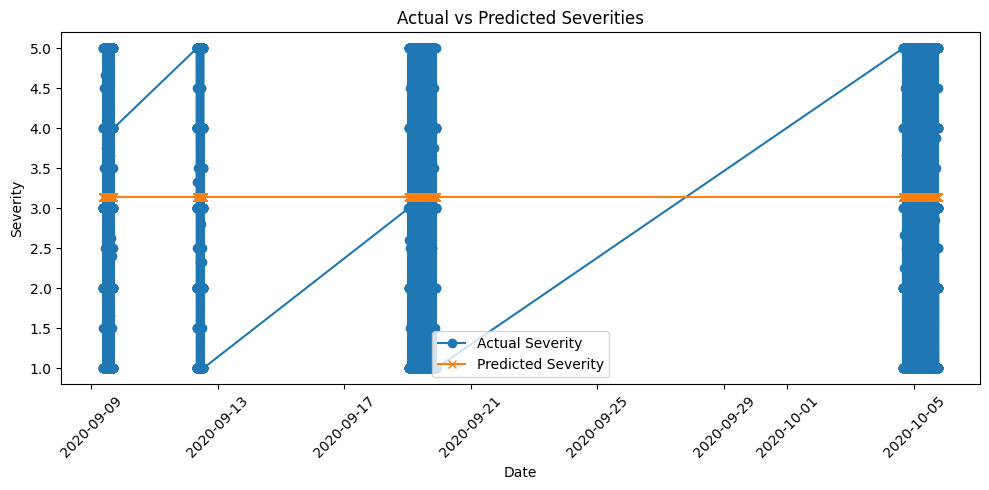

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted severities versus date
plt.figure(figsize=(10, 5))
plt.plot(X_test_datetime, y_test, label='Actual Severity', marker='o')
plt.plot(X_test_datetime, test_outputs.numpy(), label='Predicted Severity', marker='x')
plt.xlabel('Date')
plt.ylabel('Severity')
plt.title('Actual vs Predicted Severities')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# README file#
#upload csv file containing the twitter dataset and run the code as it is#